# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import itertools
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('zillow_data.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


None

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
1996-09    1039
1996-10    1039
1996-11    1039
1996-12    1039
1997-01    1039
1997-02    1039
1997-03    1039
1997-04    1039
1997-05    1039
1997-06    1039
1997-07    1038
1997-08    1038
1997-09    1038
1997-10    1038
1997-11    1038
1997-12    1038
1998-01    1036
1998-02    1036
1998-03    1036
1998-04    1036
1998-05    1036
1998-06    1036
1998-07    1036
1998-08    1036
           ... 
2012-01     224
2012-02     224
2012-03     224
2012-04     224
2012-05     224
2012-06     224
2012-07     206
2012-08     206
2012-09     206
2012-10     206
2012-11     206
2012-12     206
2013-01     151
2013-02     151
2013-03     151
2013-04     151
2013-05     151
2013-06     151
2013-07     109
2013-08     109
2013-09     109
2013-10     109
2013-11     109
2013-12     109
2014-01      56
2014-02      56
2014-03      56
2014-04      56
2014-05      56
2014-06      56
Length: 220, dtype: int6

In [4]:
df.Metro.value_counts()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           187
Pittsburgh                        177
Miami-Fort Lauderdale             162
Portland                          161
Detroit                           153
Atlanta                           152
Seattle                           141
St. Louis                         140
San Francisco                     134
Kansas City                       127
Phoenix                           126
Baltimore                         122
Tampa                             118
Riverside                         116
Cincinnati                        109
Denver                            106
Rochester                         100
Cleveland                          94
Indianapolis

In [5]:
df.Metro = df.Metro.fillna(value=df['City'])
df.Metro.isna().any()

False

In [6]:
df.Metro.value_counts()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      282
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           188
Pittsburgh                        177
Portland                          162
Miami-Fort Lauderdale             162
Detroit                           153
Atlanta                           153
Seattle                           141
St. Louis                         140
San Francisco                     134
Kansas City                       127
Phoenix                           126
Baltimore                         122
Tampa                             118
Riverside                         116
Cincinnati                        109
Denver                            106
Rochester                         101
Cleveland                          96
Columbus    

In [7]:
df.isnull().any(axis=1).sum()

1039

In [8]:
null_rows = df[df.isnull().any(axis=1)]
null_rows.isna().sum(axis=1)

20       105
36       213
105      207
156       93
232      111
272       93
275      107
345       87
469      167
508       93
713      201
796      107
800       87
842      207
854      107
868       87
884      165
1033     207
1252     105
1299     189
1359     183
1413      87
1434      93
1524      87
1534      93
1615      87
1754     111
1768     171
1809     177
1850     123
        ... 
14533    213
14538    123
14543    123
14548    107
14550    167
14558    201
14573    153
14577    219
14585    177
14587    207
14606     87
14618    167
14622    111
14623    213
14624    167
14633     87
14643    177
14651    111
14660    183
14666     87
14669    167
14674    167
14677    135
14682    111
14687    123
14703    117
14705    111
14706    171
14707    219
14708    213
Length: 1039, dtype: int64

In [9]:
df = df.dropna(axis=0)
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13684 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 28.5+ MB


None

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
df.isna().any().sum()

0

In [11]:
df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName']].nunique()

RegionID      13684
RegionName    13684
City           7046
State            50
Metro          1290
CountyName     1063
dtype: int64

In [12]:
df.drop(columns=['RegionID'], inplace=True)
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head(1)

,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


In [13]:
df.zipcode = df.zipcode.astype(str)
df.zipcode.dtype

dtype('O')

In [14]:
df.columns

Index(['zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank',
       '1996-04', '1996-05', '1996-06', '1996-07',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=271)

In [15]:
States = df.groupby('State').mean()
States.head()

,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,6321.035714,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,7594.443038,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,...,151079.746835,151543.037975,152002.531646,152450.632911,152951.265823,153617.721519,154274.683544,155324.050633,157058.860759,158517.088608
AR,7120.000000,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,69885.567010,70167.010309,...,133812.371134,134243.298969,134660.824742,134855.670103,134869.072165,134985.567010,135286.597938,136176.288660,137841.237113,139212.371134
AZ,4672.711628,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,119141.395349,119773.488372,...,263820.930233,265511.162791,267160.930233,268816.744186,270286.976744,271816.279070,273275.813953,274733.488372,276578.139535,278085.581395
CA,4926.221380,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,...,701490.824916,707091.835017,713395.033670,719988.973064,726330.303030,732919.023569,739242.087542,745334.090909,751997.138047,756195.959596


In [16]:
display(States)

,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,6321.035714,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,7594.443038,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,...,151079.746835,151543.037975,152002.531646,152450.632911,152951.265823,153617.721519,154274.683544,155324.050633,157058.860759,158517.088608
AR,7120.000000,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,69885.567010,70167.010309,...,133812.371134,134243.298969,134660.824742,134855.670103,134869.072165,134985.567010,135286.597938,136176.288660,137841.237113,139212.371134
AZ,4672.711628,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,119141.395349,119773.488372,...,263820.930233,265511.162791,267160.930233,268816.744186,270286.976744,271816.279070,273275.813953,274733.488372,276578.139535,278085.581395
CA,4926.221380,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,...,701490.824916,707091.835017,713395.033670,719988.973064,726330.303030,732919.023569,739242.087542,745334.090909,751997.138047,756195.959596
CO,6613.360324,142561.943320,142765.991903,142985.425101,143204.453441,143461.943320,143752.631579,144106.882591,144507.287449,145057.085020,...,384968.421053,387443.319838,389887.044534,392098.785425,394359.109312,397330.364372,400463.157895,403688.663968,407836.032389,411065.182186
CT,7825.217742,157189.516129,157063.709677,156926.612903,156778.225806,156640.322581,156525.806452,156462.903226,156439.516129,156570.161290,...,277025.806452,278666.129032,280383.870968,281137.096774,281725.000000,282175.806452,282852.419355,283826.612903,284893.548387,285431.451613
DC,2675.000000,189216.666667,188611.111111,188011.111111,187438.888889,186900.000000,186494.444444,186222.222222,186116.666667,186305.555556,...,779644.444444,782905.555556,785277.777778,786261.111111,788122.222222,790450.000000,793622.222222,798838.888889,804600.000000,806166.666667
DE,5363.384615,125784.615385,126234.615385,126665.384615,127026.923077,127346.153846,127603.846154,127838.461538,128046.153846,128357.692308,...,298211.538462,300065.384615,301511.538462,303603.846154,310088.461538,317303.846154,322692.307692,324519.230769,318903.846154,310996.153846


In [17]:
Metros = df.groupby('Metro').mean()
Metros.head()

,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
Metro,,,,,,,,,,,,,,,,,,,,,
Aberdeen,10259.500000,95910.000000,95840.000000,95800.000000,95760.000000,95710.000000,95700.000000,95700.0,95750.000000,95860.000000,...,156370.000000,158550.000000,161520.000000,163910.000000,165740.0,168050.000000,171220.000000,174520.000000,177740.000000,180520.000000
Abilene,8152.916667,60925.000000,60958.333333,61008.333333,61033.333333,61116.666667,61183.333333,61250.0,61350.000000,61425.000000,...,114075.000000,115400.000000,116700.000000,117283.333333,117700.0,118258.333333,118941.666667,119583.333333,120316.666667,120841.666667
Accident,13579.000000,48300.000000,48500.000000,48700.000000,48900.000000,49300.000000,49600.000000,50000.0,50500.000000,51000.000000,...,145000.000000,145500.000000,146300.000000,147800.000000,150400.0,151900.000000,152500.000000,153500.000000,154500.000000,154600.000000
Ada,9800.666667,38866.666667,39066.666667,39233.333333,39366.666667,39566.666667,39700.000000,39900.0,40066.666667,40233.333333,...,78533.333333,78933.333333,79366.666667,80066.666667,81200.0,82733.333333,83700.000000,85500.000000,88600.000000,90866.666667
Adair,12857.000000,44900.000000,45300.000000,45800.000000,46200.000000,46700.000000,47200.000000,47700.0,48300.000000,49000.000000,...,114400.000000,115600.000000,116700.000000,118200.000000,120600.0,122600.000000,123800.000000,125800.000000,128800.000000,130700.000000


In [18]:
Cities = df.groupby(['City']).mean()
Cities.head()

,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
City,,,,,,,,,,,,,,,,,,,,,
Abbeville,4358.000000,47900.0,47900.000000,48000.0,48100.000000,48200.000000,48400.0,48600.000000,48800.0,49100.000000,...,69500.000000,71700.0,73200.000000,73800.000000,74700.000000,76200.000000,77500.0,77300.000000,75600.0,74300.000000
Aberdeen,7313.250000,85575.0,85675.000000,85800.0,85900.000000,86050.000000,86200.0,86425.000000,86700.0,86950.000000,...,147375.000000,148275.0,149775.000000,150825.000000,151500.000000,152000.000000,152325.0,152625.000000,153050.0,153200.000000
Abilene,5026.333333,62300.0,62316.666667,62350.0,62383.333333,62483.333333,62550.0,62633.333333,62750.0,62833.333333,...,122766.666667,123450.0,124483.333333,125366.666667,126283.333333,127183.333333,128100.0,128666.666667,128900.0,129066.666667
Abingdon,7294.000000,73575.0,73725.000000,73850.0,74000.000000,74175.000000,74300.0,74450.000000,74650.0,74875.000000,...,153600.000000,154675.0,155925.000000,156600.000000,156625.000000,156525.000000,156625.0,157050.000000,157700.0,158200.000000
Abington,6224.000000,144780.0,144640.000000,144460.0,144260.000000,144120.000000,144000.0,143940.000000,143960.0,144040.000000,...,299220.000000,300320.0,301820.000000,302960.000000,304480.000000,306980.000000,310240.0,312580.000000,314420.0,315500.000000


In [19]:
df.columns

Index(['zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank',
       '1996-04', '1996-05', '1996-06', '1996-07',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=271)

In [20]:
def growth_rates(df):
    df['total_growth'] = (df['2018-04'] - df['1996-04']) / df['1996-04']
    df['10yr_growth'] = (df['2018-04'] - df['2008-04']) / df['2008-04']
    df['5yr_growth'] = (df['2018-04'] - df['2013-04']) / df['2013-04']
    df['2yr_growth'] = (df['2018-04'] - df['2016-04']) / df['2016-04']
    df['1yr_growth'] = (df['2018-04'] - df['2017-04']) / df['2017-04']

In [21]:
growth_rates(df)
growth_rates(States)
growth_rates(Metros)
growth_rates(Cities)
display(df.head(2), States.head(2), Metros.head(2), Cities.head(2))

,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,total_growth,10yr_growth,5yr_growth,2yr_growth,1yr_growth
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1018700,1024400,1030700,1033800,1030600,2.083782,0.191307,0.260827,0.062036,0.041852
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,316600,318100,319600,321100,321800,0.365295,0.523674,0.533842,0.127540,0.057162


,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,total_growth,10yr_growth,5yr_growth,2yr_growth,1yr_growth
State,,,,,,,,,,,,,,,,,,,,,
AK,6321.035714,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,...,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571,1.516288,0.152444,0.099505,0.029806,0.022010
AL,7594.443038,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,...,153617.721519,154274.683544,155324.050633,157058.860759,158517.088608,0.826327,0.014818,0.184037,0.088045,0.060544


,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,total_growth,10yr_growth,5yr_growth,2yr_growth,1yr_growth
Metro,,,,,,,,,,,,,,,,,,,,,
Aberdeen,10259.500000,95910.0,95840.000000,95800.000000,95760.000000,95710.000000,95700.000000,95700.0,95750.0,95860.0,...,168050.000000,171220.000000,174520.000000,177740.000000,180520.000000,0.882181,0.083358,0.496725,0.264500,0.178945
Abilene,8152.916667,60925.0,60958.333333,61008.333333,61033.333333,61116.666667,61183.333333,61250.0,61350.0,61425.0,...,118258.333333,118941.666667,119583.333333,120316.666667,120841.666667,0.983450,0.311003,0.329757,0.161567,0.079184


,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,total_growth,10yr_growth,5yr_growth,2yr_growth,1yr_growth
City,,,,,,,,,,,,,,,,,,,,,
Abbeville,4358.00,47900.0,47900.0,48000.0,48100.0,48200.0,48400.0,48600.0,48800.0,49100.0,...,76200.0,77500.0,77300.0,75600.0,74300.0,0.551148,0.173776,0.259322,0.136086,0.120664
Aberdeen,7313.25,85575.0,85675.0,85800.0,85900.0,86050.0,86200.0,86425.0,86700.0,86950.0,...,152000.0,152325.0,152625.0,153050.0,153200.0,0.790242,0.038996,0.260646,0.161706,0.059658


In [22]:
States_total_sort = States.sort_values('total_growth', ascending=False)
States_total_sort.head()

,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,total_growth,10yr_growth,5yr_growth,2yr_growth,1yr_growth
State,,,,,,,,,,,,,,,,,,,,,
DC,2675.000000,189216.666667,188611.111111,188011.111111,187438.888889,186900.000000,186494.444444,186222.222222,186116.666667,186305.555556,...,790450.000000,793622.222222,798838.888889,804600.000000,806166.666667,3.260548,0.384783,0.390116,0.121779,0.042449
CA,4926.221380,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,...,732919.023569,739242.087542,745334.090909,751997.138047,756195.959596,2.776807,0.411397,0.562616,0.174682,0.101375
SD,8485.300000,54320.000000,54640.000000,54960.000000,55290.000000,55660.000000,56020.000000,56390.000000,56660.000000,56980.000000,...,196290.000000,197240.000000,198290.000000,200090.000000,201530.000000,2.710052,0.317706,0.277771,0.124108,0.068444
HI,6458.843137,211811.764706,212880.392157,213807.843137,214572.549020,215203.921569,215684.313725,216072.549020,216305.882353,216666.666667,...,691611.764706,695003.921569,698821.568627,703331.372549,707037.254902,2.338045,0.196170,0.377082,0.114374,0.054234
WA,6464.345238,140589.285714,140838.988095,141101.488095,141378.571429,141686.011905,142026.488095,142434.523810,142895.833333,143475.297619,...,397169.940476,401591.369048,405082.142857,408850.595238,411574.702381,1.927497,0.315549,0.628906,0.262693,0.124391


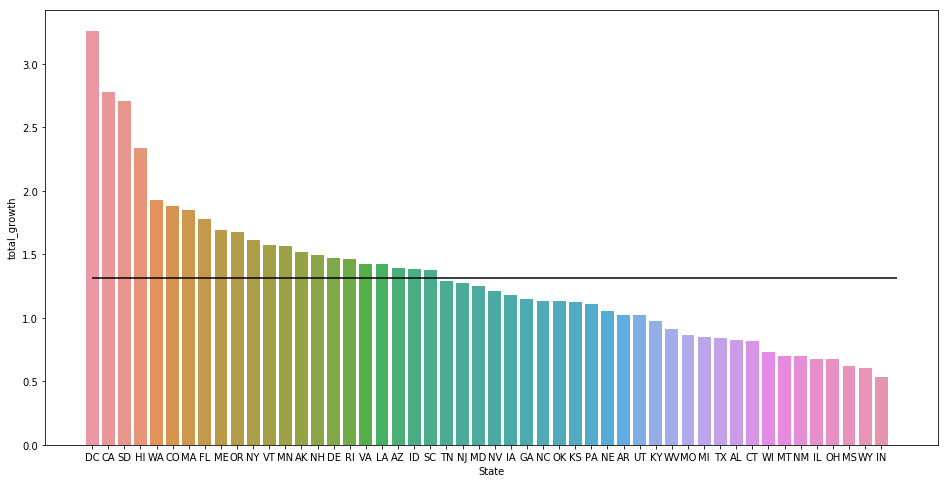

In [23]:
fig = plt.figure(figsize=(16,8))

sns.barplot(x=States_total_sort.index, y=States_total_sort.total_growth, data=States_total_sort)
plt.hlines(y=States.total_growth.mean(), xmin=0, xmax=len(States))

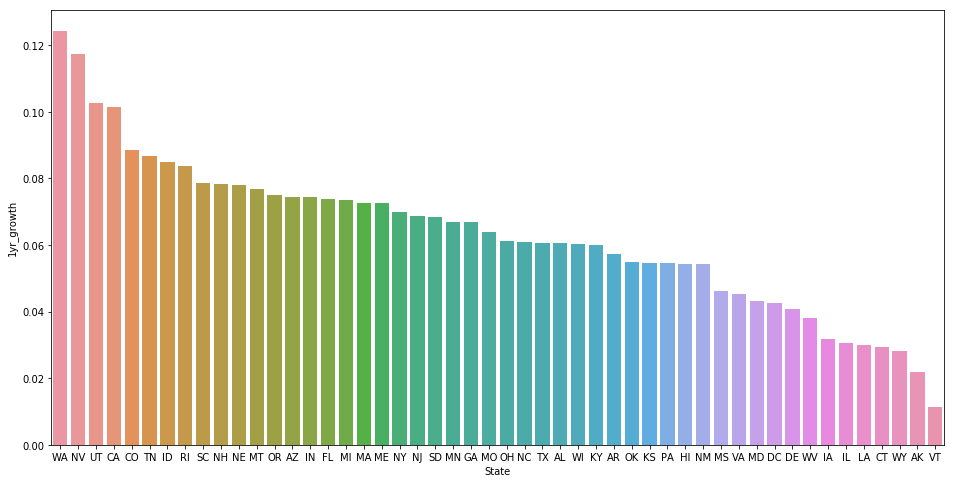

In [24]:
States_1yr_sort = States.sort_values('1yr_growth', ascending=False)
fig = plt.figure(figsize=(16,8))
sns.barplot(States_1yr_sort.index, States_1yr_sort['1yr_growth'], data=States_1yr_sort)

In [25]:
States_1yr_sort.index[:10], States_total_sort.index[:10]

(Index(['WA', 'NV', 'UT', 'CA', 'CO', 'TN', 'ID', 'RI', 'SC', 'NH'], dtype='object', name='State'),
 Index(['DC', 'CA', 'SD', 'HI', 'WA', 'CO', 'MA', 'FL', 'ME', 'OR'], dtype='object', name='State'))

In [26]:
Top_2yr_States = States.sort_values('2yr_growth', ascending=False).index[:10]
Top_2yr_States

Index(['WA', 'NV', 'UT', 'OR', 'ID', 'CO', 'TN', 'SC', 'FL', 'CA'], dtype='object', name='State')

In [27]:
Top_5yr_States = States.sort_values('5yr_growth', ascending=False).index[:10]
Top_5yr_States

Index(['NV', 'WA', 'FL', 'CA', 'OR', 'CO', 'ID', 'MI', 'UT', 'GA'], dtype='object', name='State')

In [28]:
test_list = list(enumerate(States_total_sort.index[:10]))
test_list

[(0, 'DC'),
 (1, 'CA'),
 (2, 'SD'),
 (3, 'HI'),
 (4, 'WA'),
 (5, 'CO'),
 (6, 'MA'),
 (7, 'FL'),
 (8, 'ME'),
 (9, 'OR')]

# Step 2: Data Preprocessing

In [29]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Step 3: EDA and Visualization

In [30]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    #return melted.groupby('time').aggregate({'value':'mean'})
    return melted

In [ ]:
test_df = df.drop(columns=['RegionID', 'SizeRank'])
test_df = melt_data(test_df)
test_df.head(20)

In [ ]:
test_df.shape

In [ ]:
states = sorted(list(set(test_df.State.values)))
print(states)

In [ ]:
for s in states:
    b = str(s)
    s = test_df[test_df['State'] == s].groupby(['State','time']).mean()
    s['growth_rate'] = s.value.pct_change()
    s.growth_rate.plot(figsize=(12,4))
    plt.title(b)
    plt.show()

In [ ]:
test_state_df = test_df.groupby(['State', 'time']).mean()
test_state_df.head(10)

In [ ]:
test_state_df['roll'] = test_state_df.value.pct_change()
test_state_df.head()

In [ ]:
test_state_df.roll.CA.plot()

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results